# 비트코인 골든크로스 & 데드크로스 분석

이 노트북은 Upbit API를 활용하여 비트코인의 골든크로스와 데드크로스를 분석합니다.

## 분석 내용
- 최근 200일 데이터 수집
- SMA20 & SMA50 이동평균선 계산
- 골든크로스/데드크로스 시각화
- 현재 시장 상태 분석


## 1. 라이브러리 임포트


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time


## 2. 비트코인 데이터 수집 (Upbit API)

최대 200개까지만 받을 수 있으므로 200일로 설정합니다.


In [2]:
url = "https://api.upbit.com/v1/candles/days"
params = {
    'market': 'KRW-BTC',
    'count': 200,  # 200일 데이터 (API 제한)
}
headers = {"accept": "application/json"}

response = requests.get(url, params=params, headers=headers)
data = response.json()

# DataFrame 변환
df = pd.DataFrame(data)
df['날짜'] = pd.to_datetime(df['candle_date_time_kst'])
df = df.sort_values('날짜')  # 날짜 오름차순 정렬
df['종가'] = df['trade_price']

print(f"📊 데이터 수집: {len(df)}일 ({df.iloc[0]['날짜'].strftime('%Y-%m-%d')} ~ {df.iloc[-1]['날짜'].strftime('%Y-%m-%d')})")


📊 데이터 수집: 200일 (2025-05-17 ~ 2025-12-02)


## 3. 이동평균선 계산 및 골든/데드 크로스 탐지


In [3]:
# 이동평균선 계산
df['SMA20'] = df['종가'].rolling(window=20).mean()
df['SMA50'] = df['종가'].rolling(window=50).mean()

# 골든/데드 크로스 구하기
df['GC'] = (df['SMA20'].shift(1) < df['SMA50'].shift(1)) & (df['SMA20'] > df['SMA50'])
df['DC'] = (df['SMA20'].shift(1) > df['SMA50'].shift(1)) & (df['SMA20'] < df['SMA50'])

# 골든크로스/데드크로스 카운트
gc_count = df['GC'].sum()
dc_count = df['DC'].sum()
print(f"\n📊 크로스 발생 횟수 (최근 200일)")
print(f"   📈 골든크로스: {gc_count}회")
print(f"   📉 데드크로스: {dc_count}회")



📊 크로스 발생 횟수 (최근 200일)
   📈 골든크로스: 2회
   📉 데드크로스: 2회


## 4. 그래프 시각화


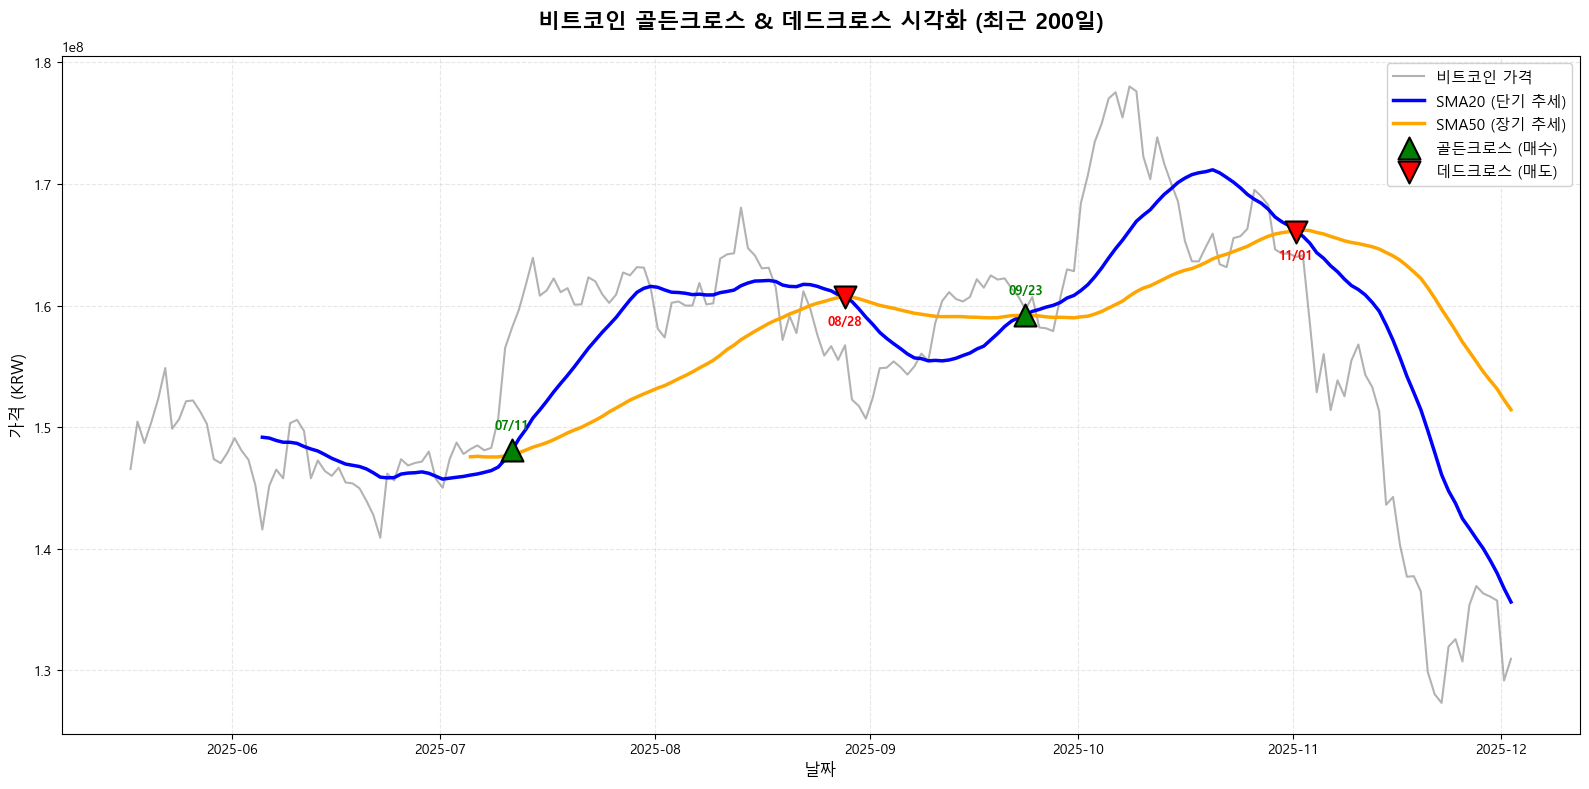

In [4]:
plt.figure(figsize=(16, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 (Windows)
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지

# 가격선과 이동평균선
plt.plot(df['날짜'], df['종가'], color='gray', alpha=0.6, linewidth=1.5, label='비트코인 가격')
plt.plot(df['날짜'], df['SMA20'], color='blue', linewidth=2.5, label='SMA20 (단기 추세)')
plt.plot(df['날짜'], df['SMA50'], color='orange', linewidth=2.5, label='SMA50 (장기 추세)')

# 골든크로스 표시 (매수 신호)
gc_dates = df.loc[df['GC'], '날짜']
gc_prices = df.loc[df['GC'], 'SMA20']
if len(gc_dates) > 0:
    plt.scatter(gc_dates, gc_prices, color='green', marker='^', s=250, 
                label='골든크로스 (매수)', zorder=5, edgecolors='black', linewidths=1.5)
    # 골든크로스 날짜 표시
    for date, price in zip(gc_dates, gc_prices):
        plt.annotate(f'{date.strftime("%m/%d")}', 
                    xy=(date, price), xytext=(0, 15),
                    textcoords='offset points', ha='center',
                    fontsize=9, color='green', fontweight='bold')

# 데드크로스 표시 (매도 신호)
dc_dates = df.loc[df['DC'], '날짜']
dc_prices = df.loc[df['DC'], 'SMA20']
if len(dc_dates) > 0:
    plt.scatter(dc_dates, dc_prices, color='red', marker='v', s=250, 
                label='데드크로스 (매도)', zorder=5, edgecolors='black', linewidths=1.5)
    # 데드크로스 날짜 표시
    for date, price in zip(dc_dates, dc_prices):
        plt.annotate(f'{date.strftime("%m/%d")}', 
                    xy=(date, price), xytext=(0, -20),
                    textcoords='offset points', ha='center',
                    fontsize=9, color='red', fontweight='bold')

plt.title('비트코인 골든크로스 & 데드크로스 시각화 (최근 200일)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('가격 (KRW)', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


## 5. 크로스 상세 정보


In [5]:
# 크로스 상세 정보 출력
if gc_count > 0:
    print(f"\n✅ 골든크로스 발생 날짜:")
    for idx, row in df[df['GC']].iterrows():
        print(f"   {row['날짜'].strftime('%Y-%m-%d')} - 가격: {row['종가']:,.0f}원")

if dc_count > 0:
    print(f"\n⚠️  데드크로스 발생 날짜:")
    for idx, row in df[df['DC']].iterrows():
        print(f"   {row['날짜'].strftime('%Y-%m-%d')} - 가격: {row['종가']:,.0f}원")



✅ 골든크로스 발생 날짜:
   2025-07-11 - 가격: 158,187,000원
   2025-09-23 - 가격: 159,679,000원

⚠️  데드크로스 발생 날짜:
   2025-08-28 - 가격: 156,737,000원
   2025-11-01 - 가격: 164,000,000원


## 6. 현재 시장 상태 분석 (실전 매매 신호)


In [6]:
print("="*70)
print("🔥 현재 시장 상태 분석 (실전 매매 신호)")
print("="*70)

latest = df.iloc[-1]  # 가장 최근 데이터
previous = df.iloc[-2]  # 전날 데이터

print(f"\n📅 기준 날짜: {latest['날짜'].strftime('%Y-%m-%d %H:%M')}")
print(f"💰 현재 가격: {latest['종가']:,.0f}원")
print(f"📊 SMA20:    {latest['SMA20']:,.0f}원")
print(f"📊 SMA50:    {latest['SMA50']:,.0f}원")


🔥 현재 시장 상태 분석 (실전 매매 신호)

📅 기준 날짜: 2025-12-02 09:00
💰 현재 가격: 130,961,000원
📊 SMA20:    135,630,200원
📊 SMA50:    151,435,740원


In [7]:
# 현재 추세 판단
if pd.notna(latest['SMA20']) and pd.notna(latest['SMA50']):
    gap = latest['SMA20'] - latest['SMA50']
    gap_percent = (gap / latest['SMA50']) * 100
    
    print(f"\n📏 SMA 간격: {gap:,.0f}원 ({gap_percent:+.2f}%)")
    
    # 골든크로스/데드크로스 체크
    if latest['GC']:
        print("\n" + "🎉"*20)
        print("🚀🚀🚀 골든크로스 발생! 🚀🚀🚀")
        print("💡 매수 신호: 상승 추세 전환 가능성")
        print("📈 추천 행동: 매수 고려 (분할 매수 권장)")
        print("🎉"*20)
    elif latest['DC']:
        print("\n" + "⚠️"*20)
        print("📉📉📉 데드크로스 발생! 📉📉📉")
        print("💡 매도 신호: 하락 추세 전환 가능성")
        print("🔻 추천 행동: 매도 고려 또는 관망")
        print("⚠️"*20)
    else:
        # 크로스는 없지만 현재 추세 분석
        if latest['SMA20'] > latest['SMA50']:
            print("\n✅ 현재 상태: 골든크로스 유지 중 (상승 추세)")
            
            # 추세 강도 분석 (더 상세하게)
            if gap_percent > 10:
                print("🔥 추세 강도: 매우 강함! (간격 10% 이상)")
                print("⚠️  경고: 과열 구간! 조정 가능성 높음")
                print("💡 추천: 일부 익절 고려, 신규 매수 자제")
            elif gap_percent > 5:
                print("💪 추세 강도: 강함 (간격 5-10%)")
                print("✅ 건강한 상승장")
                print("📈 추천: 홀딩 유지, 추가 매수 가능")
            elif gap_percent > 2:
                print("😊 추세 강도: 보통 (간격 2-5%)")
                print("✅ 안정적인 상승")
                print("📊 추천: 홀딩 (분할 매수 고려)")
            elif gap_percent > 0.5:
                print("😐 추세 강도: 약함 (간격 0.5-2%)")
                print("⚠️  불안정 구간")
                print("🔍 추천: 주의 관찰 (데드크로스 가능성)")
            else:
                print("😰 추세 강도: 매우 약함 (간격 0.5% 이하)")
                print("⚠️  곧 데드크로스 가능!")
                print("🚨 추천: 매도 준비 또는 손절 라인 설정")
                
            # 가격이 SMA20 위/아래 체크
            price_vs_sma20 = ((latest['종가'] - latest['SMA20']) / latest['SMA20']) * 100
            if price_vs_sma20 > 3:
                print(f"✅ 가격이 SMA20 위 +{price_vs_sma20:.1f}%: 매우 건강")
            elif price_vs_sma20 > 0:
                print(f"✅ 가격이 SMA20 위 +{price_vs_sma20:.1f}%: 건강한 상태")
            elif price_vs_sma20 > -3:
                print(f"⚠️  가격이 SMA20 아래 {price_vs_sma20:.1f}%: 조정 중")
            else:
                print(f"🚨 가격이 SMA20 아래 {price_vs_sma20:.1f}%: 위험 신호")
                
        else:
            print("\n❌ 현재 상태: 데드크로스 유지 중 (하락 추세)")
            
            # 하락 추세 강도 (더 상세하게)
            if gap_percent < -10:
                print("⚡ 추세 강도: 매우 강한 하락! (간격 -10% 이하)")
                print("💀 공포장! 패닉 상태")
                print("🔻 추천: 손절 완료했으면 관망, 저점 매수 기회 찾기")
            elif gap_percent < -5:
                print("💀 추세 강도: 강한 하락 (간격 -5% ~ -10%)")
                print("📉 폭락 진행 중")
                print("🔻 추천: 손절 또는 관망")
            elif gap_percent < -2:
                print("😔 추세 강도: 보통 하락 (간격 -2% ~ -5%)")
                print("📉 하락 추세 지속")
                print("⚠️  추천: 신중한 관망, 반등 대기")
            elif gap_percent < -0.5:
                print("🤔 추세 강도: 약한 하락 (간격 -0.5% ~ -2%)")
                print("📊 불안정한 하락")
                print("💡 추천: 골든크로스 전환 대기")
            else:
                print("😰 추세 강도: 매우 약한 하락 (간격 -0.5% 이상)")
                print("⚠️  곧 골든크로스 가능!")
                print("🔍 추천: 매수 타이밍 포착 준비")
                
            # 가격이 SMA20 위/아래 체크
            price_vs_sma20 = ((latest['종가'] - latest['SMA20']) / latest['SMA20']) * 100
            if price_vs_sma20 < -3:
                print(f"🚨 가격이 SMA20 아래 {price_vs_sma20:.1f}%: 급락 중")
            elif price_vs_sma20 < 0:
                print(f"⚠️  가격이 SMA20 아래 {price_vs_sma20:.1f}%: 하락 중")
            else:
                print(f"🤔 가격이 SMA20 위 +{price_vs_sma20:.1f}%: 반등 시도?")



📏 SMA 간격: -15,805,540원 (-10.44%)

❌ 현재 상태: 데드크로스 유지 중 (하락 추세)
⚡ 추세 강도: 매우 강한 하락! (간격 -10% 이하)
💀 공포장! 패닉 상태
🔻 추천: 손절 완료했으면 관망, 저점 매수 기회 찾기
🚨 가격이 SMA20 아래 -3.4%: 급락 중


In [8]:
# 최근 며칠간 추세 변화
print(f"\n📊 최근 추세 변화:")
for i in range(min(5, len(df))):
    idx = -(i+1)
    row = df.iloc[idx]
    date_str = row['날짜'].strftime('%m/%d')
    price_str = f"{row['종가']:>12,.0f}원"
    
    if pd.notna(row['SMA20']) and pd.notna(row['SMA50']):
        trend = "📈 상승" if row['SMA20'] > row['SMA50'] else "📉 하락"
        cross = ""
        if row['GC']:
            cross = "  🎉 골든크로스!"
        elif row['DC']:
            cross = "  ⚠️ 데드크로스!"
        print(f"   {date_str}: {price_str}  {trend}{cross}")

print("="*70)



📊 최근 추세 변화:
   12/02:  130,961,000원  📉 하락
   12/01:  129,172,000원  📉 하락
   11/30:  135,744,000원  📉 하락
   11/29:  136,073,000원  📉 하락
   11/28:  136,334,000원  📉 하락
